In [13]:
# Imports 
import os
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras 
from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, Activation, MaxPooling2D, GlobalAveragePooling2D

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
expression_header = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']

In [4]:
# load the data
base_path = '/kaggle/input/ferplus/FER2013Plus'

test_folder = 'FER2013Test'
train_folder = 'FER2013Train'
valid_folder = 'FER2013Valid'

labels = {
    'train' : pd.read_csv(os.path.join(base_path, 'Labels', train_folder, 'label.csv'), names=expression_header),
    'test' : pd.read_csv(os.path.join(base_path, 'Labels', test_folder, 'label.csv'), names=expression_header),
    'valid' : pd.read_csv(os.path.join(base_path, 'Labels', valid_folder, 'label.csv'), names=expression_header)
}

y_train = labels['train'][expression_header].values / 10
y_test = labels['test'][expression_header].values / 10
y_val = labels['valid'][expression_header].values / 10

print(y_train.shape, y_test.shape, y_val.shape)

(28558, 10) (3573, 10) (3579, 10)


In [5]:
# load images
X_train, X_test, X_val = [], [], []

for idx, row in tqdm(labels['train'].iterrows(), desc='training images : ', unit='img', total=labels['train'].index.size):
    img_path = os.path.join(base_path, 'Images', train_folder, idx[0])
    img = np.asarray(
            Image.open(
                img_path
            ).convert("L")
        )
    X_train.append(img)

for idx, row in tqdm(labels['test'].iterrows(), desc='testing images : ', unit='img', total=labels['test'].index.size):
    img_path = os.path.join(base_path, 'Images', test_folder, idx[0])
    img = np.asarray(
            Image.open(
                img_path
            ).convert("L")
        )
    X_test.append(img)

for idx, row in tqdm(labels['valid'].iterrows(), desc='validation images : ', unit='img', total=labels['valid'].index.size):
    img_path = os.path.join(base_path, 'Images', valid_folder, idx[0])
    img = np.asarray(
            Image.open(
                img_path
            ).convert("L")
        )
    X_val.append(img)
        
X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(X_val)

validation images : 100%|██████████| 3579/3579 [00:12<00:00, 283.16img/s]


neutral:0.0 happiness:1.0 surprise:0.0 sadness:0.0 anger:0.0 disgust:0.0 fear:0.0 contempt:0.0 unknown:0.0 NF:0.0


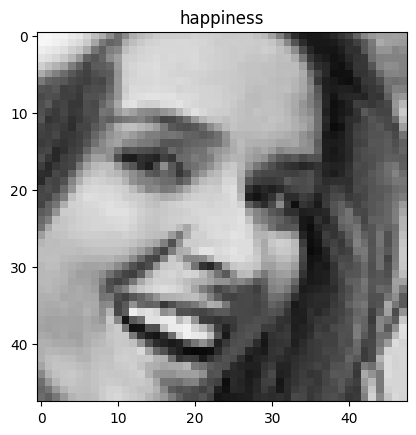

In [6]:
idx = 10
print(' '.join(f'{expr}:{prb}' for expr, prb in zip(expression_header, y_test[idx])))
plt.title(expression_header[np.argmax(y_test[idx])])
plt.imshow(X_test[idx], cmap='gray', vmin=0, vmax=255)

In [7]:
# Reshpae the data
X_train = X_train.reshape(-1,48,48,1)
X_test = X_test.reshape(-1,48,48,1)

# Normalization 255 => (-1,1)
X_train = (X_train-127.5)/127.5
X_test = (X_test-127.5)/127.5 

In [10]:
# model
model = Sequential()
params = {
    'kernel_size':(3,3), 'strides':(1,1), 'padding':'valid', 'activation':None, 'use_bias':False
}
model.add(Conv2D(filters=32, input_shape=(X_train.shape[1:]), **params))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=64, **params))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=96, **params))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=128, **params))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=156, **params))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D())
model.add(Flatten())   
model.add(Dense(units=10))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        288       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18432     
                                                                 
 dropout (Dropout)           (None, 44, 44, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                       

In [11]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3,
                                verbose=1, 
                                factor=0.1,
                                min_lr=0.00001)

In [15]:
history = model.fit(X_train[:20000], y_train[:20000],
                  batch_size=128,
                  epochs=25,
                  callbacks=[reduceLROnPlateau, ModelCheckpoint("best_model.h5", save_best_only=True)], 
                  validation_data=(X_train[20000:], y_train[20000:])
        )

Epoch 1/25
157/157 [==============================] - 270s 2s/step - loss: 1.0382 - accuracy: 0.7919 - val_loss: 1.1341 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 2/25


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 262s 2s/step - loss: 1.0191 - accuracy: 0.8034 - val_loss: 1.1415 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 3/25
157/157 [==============================] - 263s 2s/step - loss: 1.0130 - accuracy: 0.8040 - val_loss: 1.1555 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 4/25
157/157 [==============================] - 263s 2s/step - loss: 1.0136 - accuracy: 0.8061 - val_loss: 1.1210 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 5/25
157/157 [==============================] - 263s 2s/step - loss: 1.0066 - accuracy: 0.8088 - val_loss: 1.1854 - val_accuracy: 0.7369 - lr: 0.0010
Epoch 6/25
157/157 [==============================] - 266s 2s/step - loss: 1.0092 - accuracy: 0.8106 - val_loss: 1.1771 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 7/25
157/157 [==============================] - 268s 2s/step - loss: 1.0032 - accuracy: 0.8152 - val_loss: 1.1848 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 8/25
157/157 [==============================] - 262s 2s/step - loss: 

In [16]:
model.evaluate(X_test, y_test)

112/112 [==============================] - 8s 69ms/step - loss: 1.1619 - accuracy: 0.7495


[1.1619404554367065, 0.7495102286338806]

In [17]:
model.save("model_0.h5")

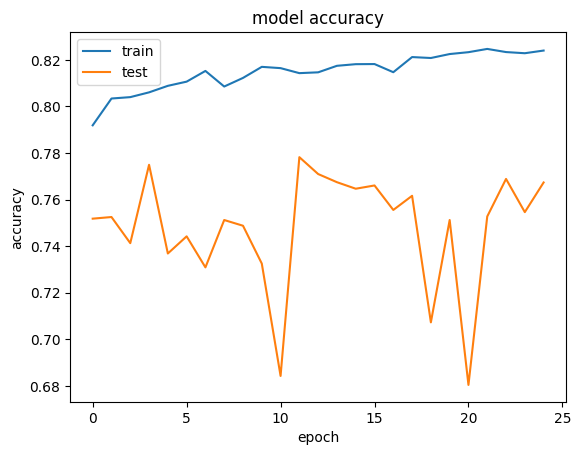

In [21]:
# history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()